In [1]:
import os
import re
import json
import socket
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import utils as pu
from pyspark.sql import functions as F
from pyspark.sql import types as pt

## Assignment #1 

This task rely on to 

In [2]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '4g').set("spark.executor.instances", "4")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st102710/


22/06/10 12:13:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Songs 

The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language


In [3]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


## "Train" data

Some data of users listen history 

- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


In [4]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

listen_history.show()

+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|                msno|             song_id|source_system_tab| source_screen_name|        source_type|target|
+--------------------+--------------------+-----------------+-------------------+-------------------+------+
|FGtllVqz18RPiwJj/...|BBzumQNXUHKdEBOB7...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4...|bhp/MpSNoqoxOIB+/...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|JNWfrrC7zNN7BdMps...|       my library|Local playlist more|     local-playlist|     1|
|Xumu+NIjS6QYVxDS4...|2A87tzfnJTSWqD7gI...|       my library|Local playlist more|     local-playlist|     1|
|FGtllVqz18RPiwJj/...|3qm6XTZ6MOCU11x8F...|          explore|            Explore|    online-playlist|     1|
|FGtllVqz18RPiwJj/...|3Hg5kugV1S0wzEVLA...|          explore|            Explore|    online-playlist|     1|
|Xumu+NIjS6QYVxDS4.

## Assignment:

PREFER DATA FRAME API(!)

Vision of result:
- self-sufficient jupyter notebook
- not only the code but n
- published on github 
- link to your github attached here https://docs.google.com/spreadsheets/d/1F8ScpCCiBaxiyZqDd09jn6t25pykiK8oauJbRuuA8Q4/edit?usp=sharing


Task 1: 
- Find out top-20 of most popular artist's in terms of: raw listens, unique users listens;

Task 2: 
- find out top-3 languages by num of raw listens
- build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre? 

Deadlines:
- soft 17.05
- hard 24.05

### Task #1 

In [5]:
#Prepare dataframes

listen_history.createTempView("listen_history")
songs.createTempView("songs")

In [6]:
#Raw listeners

spark.sql("""
SELECT songs.artist_name as name, count(msno) as appearances
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY artist_name
ORDER BY count(msno) desc
""").toPandas().head(21)


,name,appearances
0,Various Artists,303617
1,周杰倫 (Jay Chou),186776
2,五月天 (Mayday),182088
3,林俊傑 (JJ Lin),115325
4,田馥甄 (Hebe),104946
5,aMEI (張惠妹),82799
6,陳奕迅 (Eason Chan),76035
7,玖壹壹,70445
8,G.E.M.鄧紫棋,67297
9,BIGBANG,61927


In [7]:
#Unique listeners

spark.sql("""
SELECT songs.artist_name as name, count(DISTINCT msno) as distinct_appearances
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY artist_name
ORDER BY count(DISTINCT msno) desc
""").toPandas().head(21)

,name,distinct_appearances
0,Various Artists,22256
1,田馥甄 (Hebe),18771
2,周杰倫 (Jay Chou),18727
3,五月天 (Mayday),18183
4,林俊傑 (JJ Lin),17160
5,陳奕迅 (Eason Chan),16290
6,G.E.M.鄧紫棋,16064
7,Eric 周興哲,15672
8,謝和弦 (R-chord),15313
9,aMEI (張惠妹),15169


### Task #2

In [8]:
#Top 3 by raw listens

spark.sql("""
SELECT songs.language as Language, count(msno) as count
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY songs.language
ORDER BY count(msno) desc
""").toPandas().head(3)

,Language,count
0,3.0,4044643
1,52.0,1864788
2,31.0,656623


In [9]:
#From SQL to Pandas

song_duration = spark.sql("""
SELECT language, sum(song_length) as song_lenght
FROM songs
GROUP BY language
ORDER BY song_lenght desc
""").toPandas()

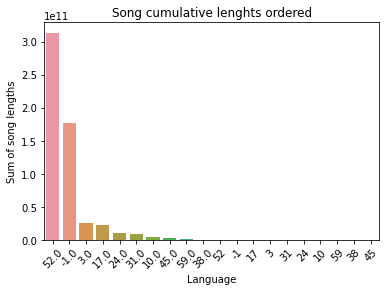

In [10]:
#Visualisating the data with sum

sns.barplot(x="language", y="song_lenght", data = song_duration)

plt.title("Song cumulative lenghts ordered")
plt.ylabel("Sum of song lengths")
plt.xlabel("Language")
plt.xticks(rotation=45)

plt.show()

In [11]:
#From SQL to Pandas

mean_duration = spark.sql("""
SELECT language, mean(song_length) as mean_lenght
FROM songs
GROUP BY language
ORDER BY mean_lenght desc
""").toPandas()

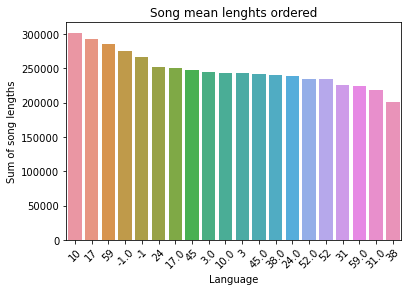

In [12]:
#Visualisating the data with mean

sns.barplot(x="language", y="mean_lenght", data = mean_duration)

plt.title("Song mean lenghts ordered")
plt.ylabel("Sum of song lengths")
plt.xlabel("Language")
plt.xticks(rotation=45)

plt.show()

### At this point, we may note that songs with id 52.0 and -1.0 lead, when cumulative lenght is used
### It is less extreme with mean lenght, with -1.0 and 52.0 are still major

In [13]:
#From SQL to pandas

genre_duration = spark.sql("""
SELECT genre_ids, sum(song_length) as sum_length, count(song_length) as count_appearance
FROM songs
GROUP BY genre_ids
ORDER BY sum_length desc
""").toPandas()

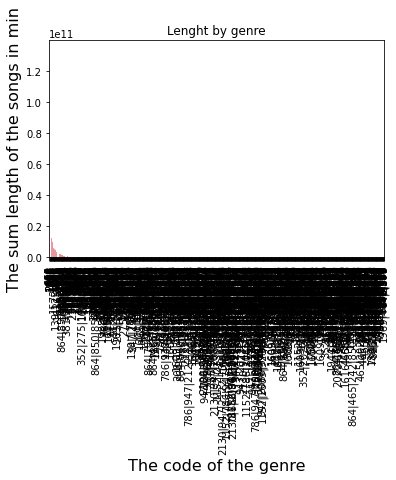

In [14]:
#Visualising the data by genre

sns.barplot(x="genre_ids", y="sum_length", data=genre_duration)

plt.title("Lenght by genre")
plt.xlabel("The code of the genre", fontsize=16);
plt.ylabel("The sum length of the songs in min", fontsize=16)
plt.xticks(rotation=90)
plt.show()

### The figure above can not nearly being read, it might be better with the just the head

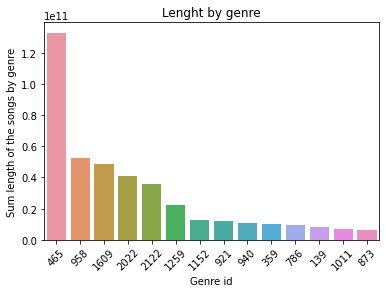

In [15]:
#Visualising only the largest genres to make it readable

sns.barplot(x="genre_ids", y="sum_length", data=genre_duration.head(15))

plt.title("Lenght by genre")
plt.xlabel("Genre id")
plt.ylabel("Sum length of the songs by genre")
plt.xticks(rotation=45)
plt.show()

### Genre 465 is definitely in the most popular genre

### It is hard to tell which is the most interesting between language and genre, it depends in good part about what you want to know. However, I tend to think that genre is a more indicative measure for lenght 